<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_4/assignment_4_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 22

# Student 1: Ruichen Hu(1674544)

# Student 2: Simin Sun(1692933)

# Student 3: Siyue Chen(1657402)

# Imports

In [ ]:
import numpy as np
import pickle
import requests
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# other imports go here

# Data loading and inspection

In [ ]:
# load and inspect data
data_location = 'https://surfdrive.surf.nl/files/index.php/s/K3ArFDQJb5USQ6K/download'
data_request = requests.get(data_location)
full_data = pickle.loads(data_request.content)

In [ ]:
for key in full_data.keys():
    data = full_data[key]
    if isinstance(data, np.ndarray):
        print(f"{key}:\t\tdata: {data.shape}, unlabeled, {type(data)}")
    else:
        ks = list(data.keys())
        x = data[ks[0]]
        y = data[ks[1]]
        if(key == "labeled_data"):
            print(f"{key}:\t\tdata: {x.shape}, label: {y.shape}, {type(x)}")
        else:
            print(f"{key}:\tdata: {x.shape}, label: {y.shape}, {type(x)}")

unlabeled_data:		data: (26000, 1, 32, 32), unlabeled, <class 'numpy.ndarray'>
labeled_data:		data: (2000, 1, 32, 32), label: (2000, 5), <class 'numpy.ndarray'>
representative_set_1:	data: (1052, 1, 32, 32), label: (1052, 6), <class 'numpy.ndarray'>
representative_set_2:	data: (1052, 1, 32, 32), label: (1052, 6), <class 'numpy.ndarray'>


In [ ]:
# convert a list of tensors to a tensor
def list2tensor(input):
    dim = [input[0].shape[i] for i in range(len(input[0].shape))]
    dim.insert(0, len(input))
    res = torch.zeros(dim)
    for i, tensor in enumerate(input):
        res[i] = tensor
    return res

def generate_dataloader(x_list, y_list, bs=100):
    x = list2tensor(x_list)
    y = list2tensor(y_list)
    td = TensorDataset(x, y)
    return DataLoader(td, batch_size=bs)

There are 4 datasets available for training and test:
- The first dataset with 26000 unlabeled data is used only to visualize the results of the trained model in classification task. We construct a dataloader **`vis_dataloader`**
- The second dataset with 2000 labeled data is used to train the VAE. We construct a dataloader **`train_cls_dataloader`**
- The third dataset consisting 1052 labeled anomalous and nonanomalous data is combined with the trained model to get the ROC curve to determine the threshold of anomaly detection. We construct one dataloader **`val_in_dis_dataloader`** for in-distribution data and one **`val_out_dis_dataloader`** for anomalous data.
- The fourth dataset consisting 1052 labeled anomalous and nonanomalous data is to test whether the threshold works for unseen data. We construct one dataloader **`test_in_dis_dataloader`** for in-distribution data and one **`test_out_dis_dataloader`** for anomalous data.
- We also construct a dataloader **`classification_dataloader`**, which consists of all labeled data in the third dataset and the fourth dataset, to test the performance of the trained model on classifying unseen data and obtain the test accuracy.

In [ ]:
label_name = ['Trousers', 'Sandal', 'Sneaker', 'Bag', 'Ankle boot']
x_dim = 32

keys = list(full_data.keys())

subkeys = list(full_data[keys[1]].keys())
# add the sixth label to the labels of training set, bacause the input is 6 instead of 5
sub_y = np.hstack((full_data[keys[1]][subkeys[1]], np.zeros((full_data[keys[1]][subkeys[1]].shape[0],1))))
train_cls_data = TensorDataset(torch.tensor(full_data[keys[1]][subkeys[0]], dtype=torch.float) / 255, torch.tensor(sub_y, dtype=torch.float))
n_classes = sub_y.shape[1]

subkeys = list(full_data[keys[2]].keys())
val_data = TensorDataset(torch.tensor(full_data[keys[2]][subkeys[0]], dtype=torch.float) / 255, torch.tensor(full_data[keys[2]][subkeys[1]], dtype=torch.float))

subkeys = list(full_data[keys[3]].keys())
test_data = TensorDataset(torch.tensor(full_data[keys[3]][subkeys[0]], dtype=torch.float) / 255, torch.tensor(full_data[keys[3]][subkeys[1]], dtype=torch.float))

# task 2: distribution with respect to 5 modes
# training with the labeled data from the second dataset(if not sufficient, the third dataset may be included)
train_cls_dataloader = DataLoader(train_cls_data, batch_size=100)

# task 3: test classification
# test the classification accuracy with the labeled data from the third and fourth dataset
# test set for classifier
test_in_dis_x = [x for x, y in val_data if y[-1] == 0]
test_in_dis_x.extend([x for x, y in test_data if y[-1] == 0])
test_in_dis_y = [y for x, y in val_data if y[-1] == 0]     # size: 5
test_in_dis_y.extend([y for x, y in test_data if y[-1] == 0])
classification_dataloader = generate_dataloader(test_in_dis_x, test_in_dis_y, bs=100)
# use vis_dataloader to visualization the classification
vis_data = TensorDataset(torch.tensor(full_data[keys[0]], dtype=torch.float) / 255)
vis_dataloader = DataLoader(vis_data, batch_size=10)

# task 1: anomaly
# use the third dataset to get ROC curve and threshold
# normal for determine ROC threshols
val_in_dis_x = [x for x, y in val_data if y[-1] == 0]
val_in_dis_y = [y for x, y in val_data if y[-1] == 0]
val_in_dis_dataloader = generate_dataloader(val_in_dis_x, val_in_dis_y, bs=100)
# anomaly for determine ROC threshols
val_out_dis_x = [x for x, y in val_data if y[-1] != 0]
val_out_dis_y = [y for x, y in val_data if y[-1] != 0]
val_out_dis_dataloader = generate_dataloader(val_out_dis_x, val_out_dis_y, bs=10)

# use the fourth dataset to test the threshold
# normal for test threshold
test_in_dis_x = [x for x, y in test_data if y[-1] == 0]
test_in_dis_y = [y for x, y in test_data if y[-1] == 0]
test_in_dis_dataloader = generate_dataloader(test_in_dis_x, test_in_dis_y, bs=100)
# anomaly for test threshold
test_out_dis_x = [x for x, y in test_data if y[-1] != 0]
test_out_dis_y = [y for x, y in test_data if y[-1] != 0]
test_out_dis_dataloader = generate_dataloader(test_out_dis_x, test_out_dis_y, bs=10)

print(len(train_cls_dataloader), len(classification_dataloader))
print(len(val_in_dis_dataloader), len(val_out_dis_dataloader), len(test_in_dis_dataloader), len(test_out_dis_dataloader))

20 20
10 6 10 6


Let's visualize some images in a certain dataloader.

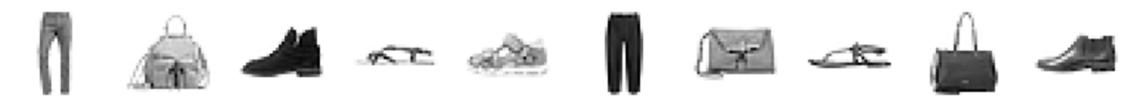

In [ ]:
import matplotlib.pyplot as plt

def show_images(x, ncols=10):
    """ plots first ncols images in a batch """
    x = x.view(-1, x_dim, x_dim)

    fig, ax = plt.subplots(1, ncols, figsize=(ncols*2, 2))
    if(ncols == 1):
        x = torch.reshape(x, (x_dim, x_dim))
        ax.imshow(x.cpu().detach().numpy(), cmap="Greys")
        ax.axis('off')
    else:
        for idx in range(ncols):
            ax[idx].imshow(x[idx].cpu().detach().numpy(), cmap="Greys")
            ax[idx].axis('off')
    plt.show()

for x in test_in_dis_dataloader:
    data = x[0]
    show_images(data)
    break

# Model definitions

## CVAE
Architecture

<img src="https://cdn.jsdelivr.net/gh/ruichen-ing/images@master/CVAE_arch.png" width=700px />

<br></br>
Implementation

<img src="https://cdn.jsdelivr.net/gh/ruichen-ing/images@master/CVAE_impl.png" width=700px />



In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_dim=5, out_dim=32*32):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.mlp(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_sigma = nn.Linear (hidden_dim, latent_dim)
        self.cnn1 = nn.Sequential(
            # input: Batch size(100) * 2 * 32 * 32
            nn.ReflectionPad2d(1),
            nn.Conv2d(2, input_dim, kernel_size=3),
            nn.LeakyReLU(0.2,inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            # 100 x 32 x 16 x 16
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.LeakyReLU(0.2,inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Sequential(
            # 100 x 64 x 8 x 8
            nn.Linear(64*8*8, hidden_dim),
            nn.ReLU(inplace=True),
            
            # 100 x 128
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        out = self.cnn1(x)
        out = out.view(out.size()[0], -1)
        out = self.fc1(out)

        # mu: mean, sigma: variance
        mu = self.fc_mu(out)
        log_sigma = self.fc_sigma(out)
        # z: latent variable vector
        z = self.reparameterization(mu, log_sigma)
        return z, mu, log_sigma
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        
        return z

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_hidden1 = nn.Linear(latent_dim + label_dim, 64 * 8 * 8)
        self.fc_hidden2 = nn.Linear(64 * 8 * 8, 64 * 8 * 8)
        self.fc_output = nn.Linear(64 * 8 * 8, output_dim)
        
    def forward(self, x, y):
        input = torch.cat((x, y), dim=1)
        out = torch.relu(self.fc_hidden1(input))
        out = torch.relu(self.fc_hidden2(out))
        x_reconstr = torch.sigmoid(self.fc_output(out))
        return x_reconstr

In [ ]:
class VAE(nn.Module):
    def __init__(self, mlp, encoder, decoder, lr):
        super(VAE, self).__init__()
        self.mlp = mlp
        self.encoder = encoder
        self.decoder = decoder
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x, y):
        emb = self.mlp(y)
        emb = emb.reshape(emb.shape[0], 1, x_dim, x_dim)
        input = torch.cat((emb, x), dim=1)
        z, mu, log_sigma = self.encoder(input)
        x_reconstr = self.decoder(z, y)
        return x_reconstr, mu, log_sigma    # three terms are used to calculate loss

In [ ]:
def loss_function(x, x_reconstr, mu, log_sigma):
    x = x.view(x.shape[0], -1)
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

# Training and validation loop


## VAE
The training data for VAE is the second dataset with 2000 data points.

In [ ]:
# write your training and validation loop here

# hyperparameters
latent_dim = 10
hidden_dim = 128

lr = 0.001
epochs = 50

mlp = MLP(in_dim=n_classes, out_dim=x_dim*x_dim)
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, label_dim=n_classes, hidden_dim=hidden_dim, output_dim=x_dim*x_dim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vae = VAE(mlp=mlp, encoder=encoder, decoder=decoder, lr=lr).to(device)

def train(dataloader, model):
    print("Start training VAE...")
    model.train()
    n_datapoints = 0
    avg_losses = []
    recon_losses = []
    kl_losses = []
    for epoch in range(epochs):
        overall_loss = 0
        overall_reconstr_loss = 0
        overall_kl_loss = 0
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            model.optimizer.zero_grad()

            x_reconstr, mu, log_sigma = model(x, y)
            loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        
            
            overall_loss += loss.item()
            overall_reconstr_loss += reconstr_loss.item()
            overall_kl_loss += kl_loss.item()
            
            loss.backward()
            model.optimizer.step()

            if epoch == 0:
                n_datapoints += x.shape[0]
        
        print(f"\tEpoch {epoch + 1} \tAverage Loss: {overall_loss / n_datapoints : 3.15f} \tReconstruction Loss: {overall_reconstr_loss / n_datapoints : 3.15f} \tKL Loss: {overall_kl_loss / n_datapoints : 3.15f}")
    
        avg_losses.append(overall_loss / n_datapoints)
        recon_losses.append(overall_reconstr_loss / n_datapoints)
        kl_losses.append(overall_kl_loss / n_datapoints)
            
    print("Training complete!")
    return avg_losses, recon_losses, kl_losses

train_losses = train(train_cls_dataloader, vae)

Start training VAE...
	Epoch 1 	Average Loss:  79.962737792968753 	Reconstruction Loss:  77.245685058593750 	KL Loss:  2.717052524566650
	Epoch 2 	Average Loss:  42.686173950195311 	Reconstruction Loss:  40.468745727539066 	KL Loss:  2.217428298950195
	Epoch 3 	Average Loss:  33.337042846679687 	Reconstruction Loss:  30.532057983398438 	KL Loss:  2.804984619140625
	Epoch 4 	Average Loss:  30.024268066406250 	Reconstruction Loss:  26.924264770507811 	KL Loss:  3.100003074645996
	Epoch 5 	Average Loss:  28.594687011718751 	Reconstruction Loss:  25.518477294921876 	KL Loss:  3.076209609985352
	Epoch 6 	Average Loss:  27.503031249999999 	Reconstruction Loss:  24.306953979492189 	KL Loss:  3.196077133178711
	Epoch 7 	Average Loss:  26.874423828125000 	Reconstruction Loss:  23.708239624023438 	KL Loss:  3.166184265136719
	Epoch 8 	Average Loss:  26.328044555664061 	Reconstruction Loss:  23.016213256835936 	KL Loss:  3.311831024169922
	Epoch 9 	Average Loss:  25.858683227539064 	Reconstructio

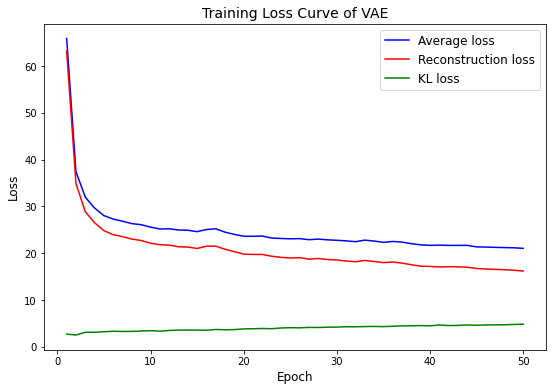

In [ ]:
from matplotlib.ticker import MaxNLocator

def plot_train_loss(loss, epoch):
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    fnt=12
    xs = [i for i in range(1, epoch+1)]
    avg_loss, recon_loss, kl_loss = loss
    ax.plot(xs, avg_loss, color='blue', label='Average loss')
    ax.plot(xs, recon_loss, color='red', label='Reconstruction loss')
    ax.plot(xs, kl_loss, color='green', label='KL loss')
    # ax.axhline(y=baseline_train_loss[idx], color="grey", linestyle="--", label="Training baseline")
    ax.set_title(f"Training Loss Curve of VAE", fontsize=14)
    ax.legend(fontsize=fnt)

    ax.set_xlabel("Epoch", fontsize=fnt)
    ax.set_ylabel("Loss", fontsize=fnt);

plot_train_loss(train_losses, epochs)

# Inspection, Validation, and Analysis

## Evaluation on image generation

Let's visualize some data samples to figure out how the reconstructed images for the both normal and anomalous classes look like.


normal images


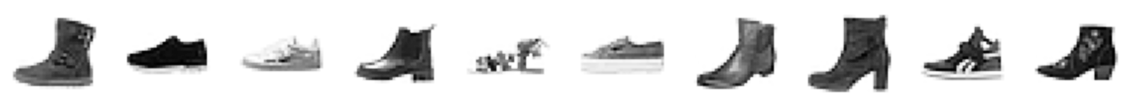

reconstructed normal images


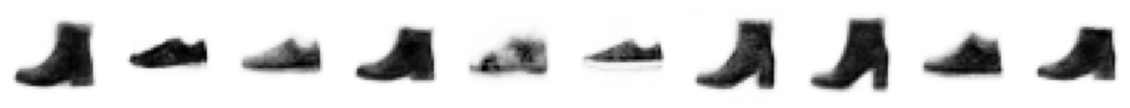

anomalous images


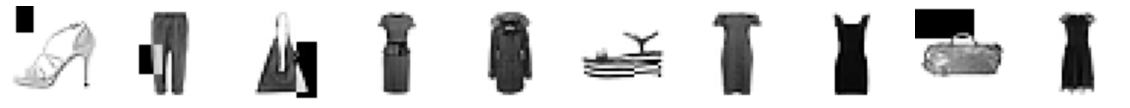

reconstructed anomalous images


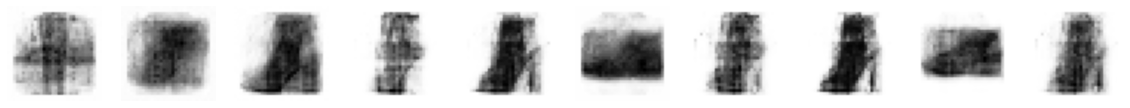

In [ ]:
def plot_images(dataloader, anomaly_dataloader, model):
    model.eval()
    with torch.no_grad():
        # reconstruciton: normal
            for x, y in dataloader:
                x = x.to(device)
                y = y.to(device)
                x_rec, _, _ = model(x, y)
                print('normal images')
                x = x.cpu()
                x_rec = x_rec.cpu()
                show_images(x)
                print('reconstructed normal images')
                show_images(x_rec)
                break

            for x, y in anomaly_dataloader:
                x = x.to(device)
                y = y.to(device)
                x_rec, _, _ = model(x, y)
                print('anomalous images')
                x = x.cpu()
                x_rec = x_rec.cpu()
                show_images(x)
                print('reconstructed anomalous images')
                show_images(x_rec)
                break

plot_images(val_in_dis_dataloader, val_out_dis_dataloader, vae)

Then we plots some generated images by feeding a specific label. That means, there is no true image fed into the network. We generate a image purely besed on the latent variables and the target label.

true images, Trousers(mode = 0)


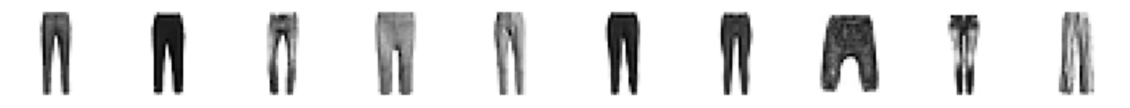

generated images, Trousers(mode = 0)


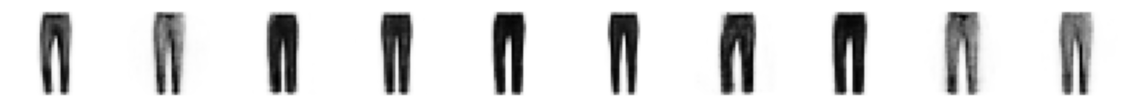

--------------------------------------------------------------------------------------------------------------------------------------------
true images, Sandal(mode = 1)


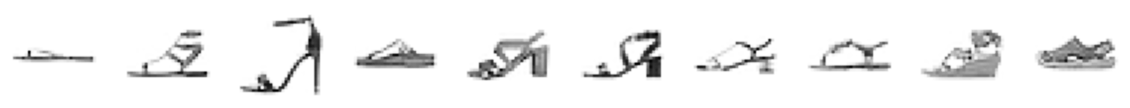

generated images, Sandal(mode = 1)


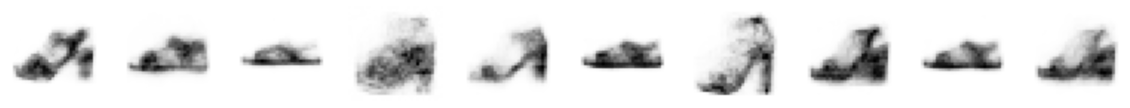

--------------------------------------------------------------------------------------------------------------------------------------------
true images, Sneaker(mode = 2)


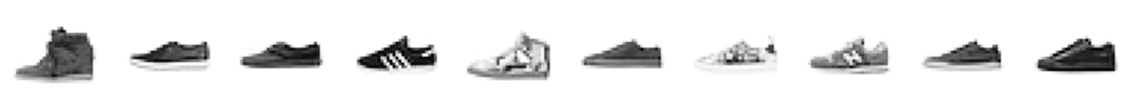

generated images, Sneaker(mode = 2)


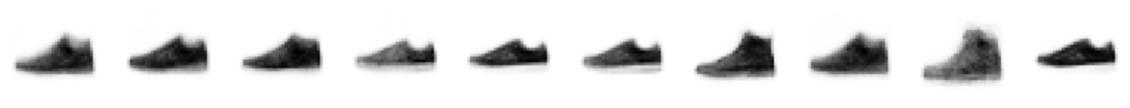

--------------------------------------------------------------------------------------------------------------------------------------------
true images, Bag(mode = 3)


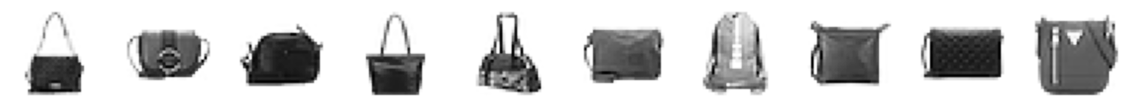

generated images, Bag(mode = 3)


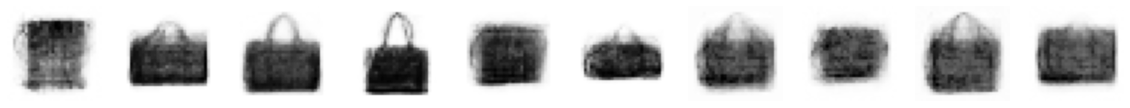

--------------------------------------------------------------------------------------------------------------------------------------------
true images, Ankle boot(mode = 4)


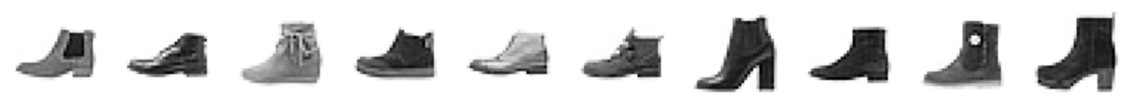

generated images, Ankle boot(mode = 4)


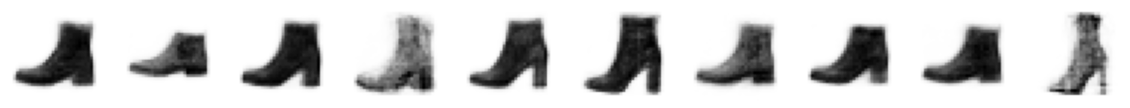

--------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
def plot_image_by_label(x_set, y_set, model, index):
    count = 0
    x = []
    for i in range(y_set.shape[0]):
        if y_set[i][index] == 1:
            x.append(x_set[i])
            count += 1
        if count == 10:
            break
    x = list2tensor(x)
    model.eval()
    print(f'true images, {label_name[index]}(mode = {index})')
    show_images(x)

def generate_images_by_label(model, label, index, num=10):
    model.eval()
    with torch.no_grad():
        # random images within the distribution of a specific class/mode
        noise = torch.randn((num, latent_dim), device=device)
        label = label.to(device)
        generated = decoder(noise, label).cpu()
        generated = generated.reshape(-1, 1, 32, 32)
        print(f'generated images, {label_name[index]}(mode = {index})')
        show_images(generated)

def generated_vs_true_images(data, model, num=10):
    for idx in range(n_classes - 1):
        subkeys = list(data[keys[1]].keys())
        # first plot the true images by mode/class
        plot_image_by_label(torch.tensor(data[keys[1]][subkeys[0]], dtype=torch.float) / 255, torch.tensor(data[keys[1]][subkeys[1]], dtype=torch.float), model, idx)

        row = [0] * 6
        row[idx] = 1
        labels = torch.tensor(np.array([row for i in range(num)]))
        # then plot the generated images with the corresponding mode/class
        generate_images_by_label(model, labels, idx)
        print('-' * 140)

generated_vs_true_images(full_data, vae)

## Evaluation on anomalies detection

In [ ]:
def elbo_elementwise(x, x_reconstr, mu, log_sigma):
    reconstr_loss = torch.sum(nn.functional.mse_loss(x_reconstr, x, reduction='none'), dim=1)
    # assuming: sigma=1/sqrt(2)
    constant_term = x_dim * 0.5 * np.log(np.pi)
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1, dim=1)
    elbo = - reconstr_loss - constant_term - kl_loss
    return elbo, reconstr_loss, kl_loss

As mentioned in **Data loading and inspection** part, we use **`val_in_dis_dataloader`**, **`val_out_dis_dataloader`** to build ROC curve and find a proper threshold. Then we apply **`test_in_dis_dataloader`**, **`test_out_dis_dataloader`** to detect anomaly in unseen data with the derived threshold.

In [ ]:
def get_losses(normal_dataloader, anomaly_dataloader, model):
    model.eval()
    normal_elbo = []
    anomaly_elbo = []
    normal_rec = []
    anomaly_rec = []

    with torch.no_grad():
        for x, y in normal_dataloader:
            x = x.to(device)
            y = y.to(device)
            x_rec, mu, log_sigma = model(x, y)
            elbo, rec, kl = elbo_elementwise(x.view(x.shape[0], -1), x_rec, mu, log_sigma)
            normal_elbo.append(elbo.cpu().numpy())
            normal_rec.append(rec.cpu().numpy())
        
        for x, y in anomaly_dataloader:
            x = x.to(device)
            y = y.to(device)
            x_rec, mu, log_sigma = model(x, y)
            elbo, rec, kl = elbo_elementwise(x.view(x.shape[0], -1), x_rec, mu, log_sigma)
            anomaly_elbo.append(elbo.cpu().numpy())
            anomaly_rec.append(rec.cpu().numpy())

        normal_elbo = np.concatenate(normal_elbo, 0)
        anomaly_elbo = np.concatenate(anomaly_elbo, 0)
        normal_rec = np.concatenate(normal_rec, 0)
        anomaly_rec = np.concatenate(anomaly_rec, 0)
        
    return normal_elbo, anomaly_elbo, normal_rec, anomaly_rec

nm_val_elbo, anm_val_elbo, nm_val_rec, anm_val_rec = get_losses(val_in_dis_dataloader, val_out_dis_dataloader, vae)
nm_test_elbo, anm_test_elbo, nm_test_rec, anm_test_rec = get_losses(test_in_dis_dataloader, test_out_dis_dataloader, vae)

To evaluate the performance of the trained VAE on anomaly detection, we plot the distribution of the reconstruciton loss and ELBO with respect to the class of the data, i.e., anumalous and nonanomalous. These figures correspond to the training process.

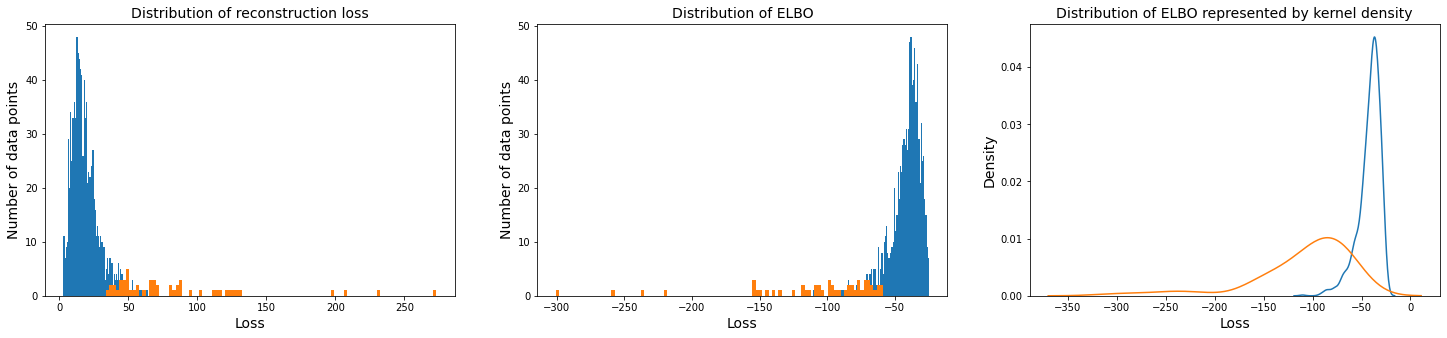

In [ ]:
from IPython.core.pylabtools import figsize
import seaborn as sns

def evaluate_vae(normal_elbo, anomaly_elbo, normal_rec, anomaly_rec):
    fn = 14    
    fig, ax = plt.subplots(1, 3, figsize=(25, 5))
    # normal的reconstruction loss集中在18，而anomaly集中在20-30
    ax[0].hist(normal_rec, bins=100)
    ax[0].hist(anomaly_rec, bins=100)
    ax[0].set_xlabel("Loss", fontsize=fn)
    ax[0].set_ylabel("Number of data points", fontsize=fn)
    ax[0].set_title("Distribution of reconstruction loss", fontsize=fn)

    # y轴是数量，x轴是ELBO loss的大小。可以看到normal的ELBO基本上集中在-470, 而anomaly集中在-480
    ax[1].hist(normal_elbo, bins=100)
    ax[1].hist(anomaly_elbo, bins=100)
    ax[1].set_xlabel("Loss", fontsize=fn)
    ax[1].set_ylabel("Number of data points", fontsize=fn)
    ax[1].set_title("Distribution of ELBO", fontsize=fn)

    ax[2] = sns.kdeplot(normal_elbo, ax=ax[2])
    ax[2].set_xlabel("Loss", fontsize=fn)
    ax[2].set_ylabel("Density", fontsize=fn)
    ax[2].set_title("Distribution of ELBO represented by kernel density", fontsize=fn)
    sns.kdeplot(anomaly_elbo, ax=ax[2])
    plt.show()

evaluate_vae(nm_val_elbo, anm_val_elbo, nm_val_rec, anm_val_rec)

In [ ]:
def labels_scores(normal_elbo, anomaly_elbo):
    normal_test_labels = np.zeros_like(normal_elbo)
    anomaly_test_labels = np.ones_like(anomaly_elbo)

    scores = - np.concatenate([normal_elbo, anomaly_elbo], axis=0)
    scores = (scores - scores.min())/(scores.max()-scores.min()) # normalize values to [0, 1]

    labels = np.concatenate([normal_test_labels, anomaly_test_labels], axis=0)
    
    return scores, labels

In [ ]:
def ROC(scores, true, scale=10001):
    thresholds = np.linspace(0.0, 1.0, num=scale)
    TPRs = []
    FPRs = []
    true = true.astype(int)

    P = np.count_nonzero(true)
    N = true.size - P
    for t in thresholds:
        pred = (scores >= t).astype(int)
        diff = pred - true
        FP = np.count_nonzero(diff == 1)
        TP = np.count_nonzero(pred == 1) - FP
        TPR = TP / P
        FPR = FP / N
        TPRs.append(TPR)
        FPRs.append(FPR)

    TPRs = np.array(TPRs)
    FPRs = np.array(FPRs)
    return FPRs, TPRs, thresholds

selected threshold: 0.1298
roc_auc=0.9855576923076923
pr_auc=0.8163761771780997


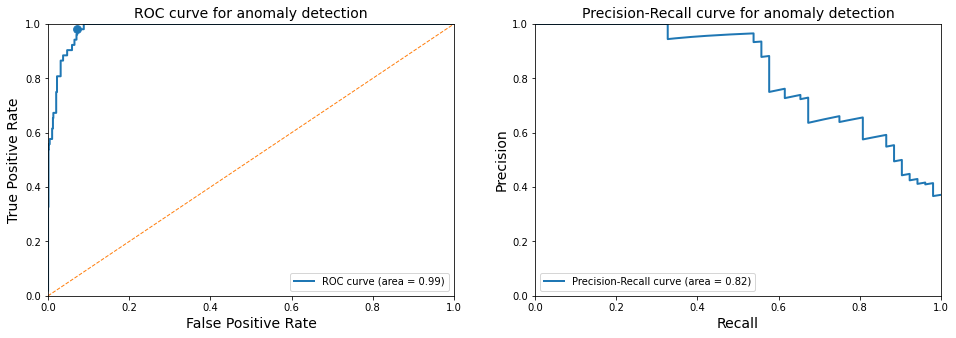

In [ ]:
def report_roc_threshold(normal_elbo, anomaly_elbo):
    scores, labels = labels_scores(normal_elbo, anomaly_elbo)

    # fpr, tpr, roc_thresholds = roc_curve(labels, scores)
    fpr, tpr, roc_thresholds = ROC(scores, labels)
    precision, recall, pr_thresholds = precision_recall_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    index = np.argmin((np.power(fpr, 2) + np.power(tpr - 1, 2)))
    threshold = roc_thresholds[index]
    print(f"selected threshold: {threshold}")
    print(f'roc_auc={roc_auc}')
    print(f'pr_auc={pr_auc}')

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    fn = 14

    ax[0].plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], lw=1, linestyle="--")
    ax[0].scatter(fpr[index], tpr[index], s=60)
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.0])
    ax[0].set_xlabel('False Positive Rate', fontsize=fn)
    ax[0].set_ylabel('True Positive Rate', fontsize=fn)
    ax[0].set_title('ROC curve for anomaly detection', fontsize=fn)
    ax[0].legend(loc='lower right')

    ax[1].plot(recall, precision, lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel('Recall', fontsize=fn)
    ax[1].set_ylabel('Precision', fontsize=fn)
    ax[1].set_title('Precision-Recall curve for anomaly detection', fontsize=fn)
    ax[1].legend(loc='lower left')
    plt.show();

    return threshold

threshold = report_roc_threshold(nm_val_elbo, anm_val_elbo)

As shown above, we draw a ROC curve with the first anomaly-containg dataset and find the threshold which corresponds to the point closest to (0, 1) on the ROC curve. Now, let's check whether this threshold works by looking at the last dataset.

The anomaly detection accuracy is derived on the dataloader by which we obtained the ROC threshold. The unseen anomaly detection accuracy is the accuracy derived by unseen data with the threshold.

In [ ]:
def evaluate_anomaly_detect(normal_elbo, anomaly_elbo, threshold):
    scores, labels = labels_scores(normal_elbo, anomaly_elbo)
    labels = labels.astype(int)

    pred = (scores >= threshold).astype(int)
    diff = pred - labels
    FP = np.count_nonzero(diff == 1)
    FN = np.count_nonzero(diff == -1)
    acc = 1 - (FP + FN) / diff.size
    
    return acc

acc = evaluate_anomaly_detect(nm_val_elbo, anm_val_elbo, threshold)
print(f"Anomaly detection accuracy: {acc}")
acc = evaluate_anomaly_detect(nm_test_elbo, anm_test_elbo, threshold)
print(f"Unseen anomaly detection accuracy: {acc}")

Anomaly detection accuracy: 0.9306083650190115
Unseen anomaly detection accuracy: 0.846958174904943


## Evaluation on classification

To apply the trained CVAE to classification tasks, we first generate for each mode/class 100 images by feeding the labels into the network. Then, we compare each image, which is going to be classified, with the generated images and calculate the average cosine similarity with respect to each mode. We use 100 images here to reduce the impacts of extreme cases or outliers. At the end, we get for each query image a list of 5 cosine similarities. We take the index of the one with the largest value among all the similarities to be the index of the predicted class. The predictions are compared with the true labels to calculate the classification accuracy on unseen data(The dataloader used here is different than the one used during training).

In [ ]:
def generate_for_classification(model, num=100):
    model.eval()
    gen_images = []
    for idx in range(n_classes - 1):
        row = [0] * 6
        row[idx] = 1
        labels = torch.tensor(np.array([row for i in range(num)]))

        with torch.no_grad():
            noise = torch.randn((num, latent_dim), device=device)
            labels = labels.to(device)
            generated = decoder(noise, labels).cpu()
        gen_images.append(generated)
    return gen_images


def compare_gen_true(data, gen_standard, num=100):
    y_pred = []
    for x in data:
        x = x.repeat(num, 1)
        cos = torch.tensor(np.array([torch.mean(nn.functional.cosine_similarity(x, gen, dim=1)).item() for gen in gen_standard]))
        idxs = torch.argmax(cos)
        pred = nn.functional.one_hot(idxs, num_classes=n_classes)
        y_pred.append(pred)

    return list2tensor(y_pred)


def classification(dataloader, model, num=100):
    model.eval()
    n_samples = 0
    loss = 0
    gen_images = generate_for_classification(model)
    with torch.no_grad():
        for x, y in dataloader:
            y_pred = compare_gen_true(x.view(x.shape[0], -1), gen_images)
            diff = torch.abs(y_pred - y)
            loss = loss + torch.sum(diff).item() / 2
            n_samples += x.shape[0]
    
    return 1 - loss / n_samples

cls_acc = classification(classification_dataloader, vae)
print(f"Classification accuracy: {cls_acc}")

Classification accuracy: 0.7515000000000001


To better evaluate the model on classification task, we plot 10 prediction results.

Predicted class: Trousers(mode = 0)
Corresponding images:


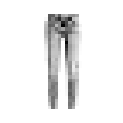

------------------------------------------------------------------------------------------------------------------------
Predicted class: Sandal(mode = 1)
Corresponding images: null
------------------------------------------------------------------------------------------------------------------------
Predicted class: Sneaker(mode = 2)
Corresponding images:


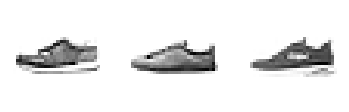

------------------------------------------------------------------------------------------------------------------------
Predicted class: Bag(mode = 3)
Corresponding images:


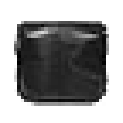

------------------------------------------------------------------------------------------------------------------------
Predicted class: Ankle boot(mode = 4)
Corresponding images:


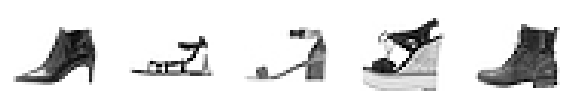

------------------------------------------------------------------------------------------------------------------------


In [ ]:
def vis_classification(dataloader, model ):
    model.eval()
    gen_images = generate_for_classification(model)
    with torch.no_grad():
        for x in dataloader:
            x = x[0]
            x.to(device)
            y_pred = compare_gen_true(x.view(x.shape[0], -1), gen_images)
            pred_labels = torch.argmax(y_pred, dim=1)
            pred_labels = torch.argmax(y_pred, dim=1).cpu().detach().numpy()

            for i in range(n_classes - 1):
                idx = np.where(pred_labels == i)
                # print(pred_labels)
                # print(idx)
                images = x[idx]
                print(f"Predicted class: {label_name[i]}(mode = {i})")
                if np.array(idx).size == 0:
                    print(f"Corresponding images: null")
                else:
                    print(f"Corresponding images:")
                    show_images(images, ncols = images.shape[0])

                print("-" * 120)

            break

vis_classification(vis_dataloader, vae)